# Problem Statement

Dataset - Fashion-MNIST

Part -1
Use OpenCV or any other library for input pipeline (transformations, augmentations,
rotation, etc..)
Only quadratic intensity scaling
(Using erode/dilate for noise removal leads to drop in accuracy)


Part -2
Build a CNN network from scratch using tensorflow on transformed data, Save model
with highest validation accuracy & use that saved model for inference.


Part -3
Modify the above architecture by using Batch normalization, dropout,
ReduceLRonPlateau, Early stopping.
Introduce batch normalization, dropout and build a model using Batch norm on
tensorflow
(batch-normalization paper)

Compare the performance of the 2 models ( Part 2 and Part 3)


# Part 1

In [1]:
# Importing packages

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load Dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

In [3]:
# Dimension of dataset
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

# Checking for missing values
missing_values_train = np.isnan(train_images).sum()
print("Number of missing values in X_train:", missing_values_train)

missing_values_test = np.isnan(test_images).sum()
print("Number of missing values in X_test:", missing_values_test)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
Number of missing values in X_train: 0
Number of missing values in X_test: 0


In [36]:
def visualize_samples(X, Y, num_samples=10):
    """
    Visualizes samples from the dataset.

    Parameters:
        X (numpy.ndarray): The input images dataset.
        Y (numpy.ndarray): The corresponding labels dataset.
        num_samples (int): The number of samples to visualize. Default is 10.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        # Randomly select an index
        idx = np.random.randint(X.shape[0])

        # Reshape and display the image
        image = X[idx].reshape(28, 28)  # Remove the extra dimension for channel
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {Y[idx]}")  # No need for np.argmax here

    plt.show()


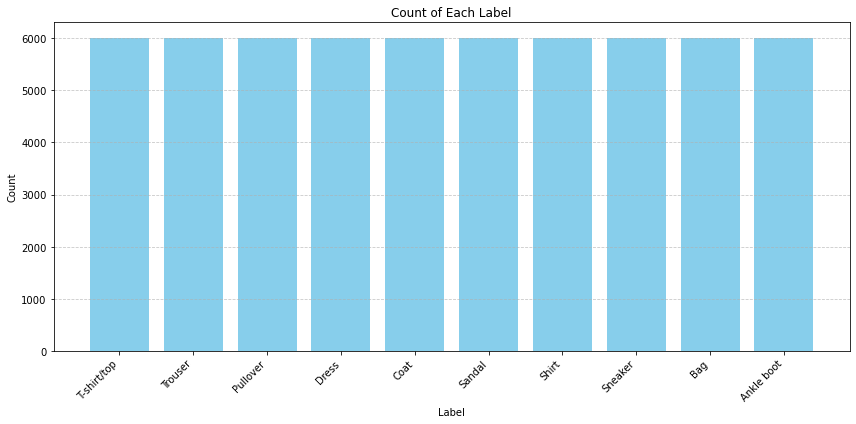

In [5]:
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_label_counts(labels):
    """
    Plots the count of each label in the dataset.

    Parameters:
        labels (numpy.ndarray): The array containing the labels of the dataset.

    Returns:
        None
    """
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(12, 6))
    plt.bar(unique_labels, label_counts, color='skyblue')
    plt.title('Count of Each Label')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(unique_labels, labels=label_names, rotation=45, ha='right')  # Set label names and rotate for better visibility
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [6]:
# Preprocessing function including quadratic intensity scaling

def preprocess_images(images):
    """
    Preprocesses a batch of images by applying quadratic intensity scaling.

    Parameters:
        images (numpy.ndarray): A batch of images to be preprocessed. Each image should be represented as a 2D numpy array.

    Returns:
        numpy.ndarray: An array containing the preprocessed images with quadratic intensity scaling applied.
            The shape of the output array is the same as the input array.

    Notes:
        - This function scales the intensity values of each pixel in the images quadratically.
        - Intensity scaling is applied by dividing each pixel value by 255.0 and then squaring the result.
        - The input images should be represented as 2D numpy arrays.
        - The output array contains preprocessed images with the same shape as the input array.
    """
    processed_images = []
    for image in images:
        # Apply quadratic intensity scaling
        scaled_image = np.square(image.astype(np.float32) / 255.0)
        processed_images.append(scaled_image)
    return np.array(processed_images)


In [10]:
# Reshape images for CNN
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

In [11]:
# Split the data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Part 2

In [12]:
# Define the CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Importing ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,      # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
    shear_range=0.2,        # shear intensity (shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,         # randomly zooms into the image
    horizontal_flip=True,   # randomly flip images horizontally
    vertical_flip=False,    # randomly flip images vertically
    fill_mode='nearest'     # strategy used for filling in newly created pixels, 'nearest' works well for most cases
)

# Fit the generator to your training data
datagen.fit(train_images)

# Train the model using augmented data
# Train the model using augmented data
augmented_history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                              steps_per_epoch=len(train_images) / 32, # This is crucial for steps_per_epoch calculation
                              epochs=50,
                              validation_data=(val_images, val_labels))


Epoch 1/50
1200/1200 [==============================] - 18s 14ms/step - loss: 0.9653 - accuracy: 0.6745 - val_loss: 0.5654 - val_accuracy: 0.7933
Epoch 2/50
1200/1200 [==============================] - 17s 15ms/step - loss: 0.6403 - accuracy: 0.7574 - val_loss: 0.5117 - val_accuracy: 0.8128
Epoch 3/50
1200/1200 [==============================] - 17s 14ms/step - loss: 0.5810 - accuracy: 0.7820 - val_loss: 0.4729 - val_accuracy: 0.8285
Epoch 4/50
1200/1200 [==============================] - 22s 18ms/step - loss: 0.5458 - accuracy: 0.7957 - val_loss: 0.4532 - val_accuracy: 0.8275
Epoch 5/50
1200/1200 [==============================] - 19s 16ms/step - loss: 0.5107 - accuracy: 0.8071 - val_loss: 0.4147 - val_accuracy: 0.8477
Epoch 6/50
1200/1200 [==============================] - 19s 16ms/step - loss: 0.4908 - accuracy: 0.8154 - val_loss: 0.4182 - val_accuracy: 0.8523
Epoch 7/50
1200/1200 [==============================] - 20s 16ms/step - loss: 0.4776 - accuracy: 0.8201 - val_loss: 0.3857 -

In [18]:
# Save the model with the highest validation accuracy
best_model_path = 'best_model.h5'
best_model_index = np.argmax(augmented_history.history['val_accuracy'])
best_model_accuracy = augmented_history.history['val_accuracy'][best_model_index]
model.save(best_model_path)

In [19]:
print(f"Model with highest validation accuracy ({best_model_accuracy:.4f}) saved as '{best_model_path}'")

Model with highest validation accuracy (0.8881) saved as 'best_model.h5'


In [20]:
# Load the best model for evaluation
best_model = tf.keras.models.load_model(best_model_path)

In [21]:
# Evaluate the model on test set
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f"\nTest Accuracy: {test_acc:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.4165 - accuracy: 0.8548

Test Accuracy: 0.8548


In [22]:
# Predictions
y_pred = np.argmax(best_model.predict(test_images), axis=-1)

313/313 [==============================] - 1s 3ms/step


In [23]:
# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average='weighted')
recall = recall_score(test_labels, y_pred, average='weighted')
f1 = f1_score(test_labels, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8548
Precision: 0.8611
Recall: 0.8548
F1 Score: 0.8522


# Confusion Matrix

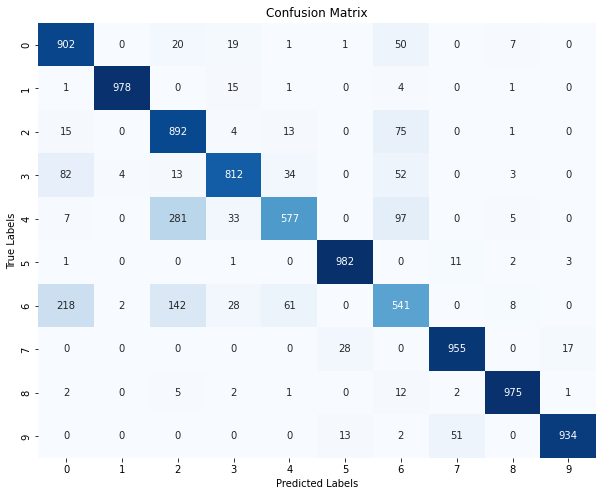

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

# Print accuracy
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=label_names))

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8548
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.73      0.90      0.81      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.66      0.89      0.76      1000
       Dress       0.89      0.81      0.85      1000
        Coat       0.84      0.58      0.68      1000
      Sandal       0.96      0.98      0.97      1000
       Shirt       0.65      0.54      0.59      1000
     Sneaker       0.94      0.95      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.98      0.93      0.96      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

Confusion Matrix:
[[902   0  20  19   1   1  50   0   7   0]
 [  1 978   0  15   1   0   4   0   1   0]
 [ 15   0 892   4  13   0  75   0   1   0]
 [ 82   4  13 812  34   0  52   0   3   0]
 [  7   0 2

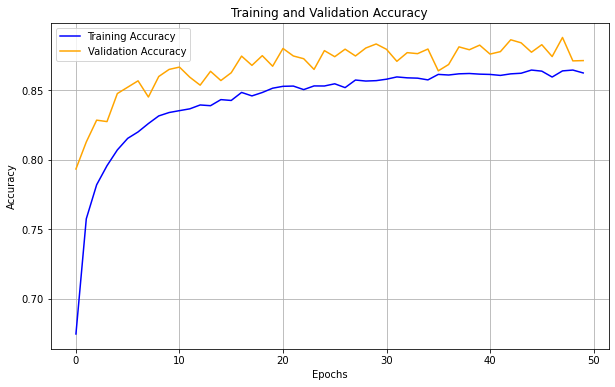

In [37]:
import matplotlib.pyplot as plt

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(augmented_history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(augmented_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Part 3

In [24]:
# Importing packages
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [25]:
# Define the enhanced CNN model architecture
enhanced_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [26]:
# Compile the enhanced model
enhanced_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [27]:
# Define callbacks for ReduceLRonPlateau and EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [28]:
# Train the enhanced model
enhanced_history = enhanced_model.fit(train_images, train_labels, epochs=50, 
                                      validation_data=(val_images, val_labels),
                                      callbacks=[reduce_lr, early_stopping])

Epoch 1/50
1200/1200 [==============================] - 23s 19ms/step - loss: 0.6563 - accuracy: 0.7732 - val_loss: 0.3805 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 2/50
1200/1200 [==============================] - 21s 18ms/step - loss: 0.4372 - accuracy: 0.8455 - val_loss: 0.3062 - val_accuracy: 0.8934 - lr: 0.0010
Epoch 3/50
1200/1200 [==============================] - 25s 21ms/step - loss: 0.3835 - accuracy: 0.8644 - val_loss: 0.2885 - val_accuracy: 0.8970 - lr: 0.0010
Epoch 4/50
1200/1200 [==============================] - 26s 22ms/step - loss: 0.3543 - accuracy: 0.8739 - val_loss: 0.2868 - val_accuracy: 0.8976 - lr: 0.0010
Epoch 5/50
1200/1200 [==============================] - 24s 20ms/step - loss: 0.3357 - accuracy: 0.8796 - val_loss: 0.2937 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 6/50
1200/1200 [==============================] - 26s 22ms/step - loss: 0.3163 - accuracy: 0.8877 - val_loss: 0.2565 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 7/50
1200/1200 [========================

In [29]:
# Evaluate the enhanced model on test set
enhanced_test_loss, enhanced_test_acc = enhanced_model.evaluate(test_images, test_labels)
print(f"\nEnhanced Model - Test Accuracy: {enhanced_test_acc:.4f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.2472 - accuracy: 0.9132

Enhanced Model - Test Accuracy: 0.9132


In [30]:
# Predictions
y_pred_enhanced = np.argmax(enhanced_model.predict(test_images), axis=-1)

313/313 [==============================] - 2s 5ms/step


In [31]:
# Calculate evaluation metrics for enhanced model
accuracy_enhanced = accuracy_score(test_labels, y_pred_enhanced)
precision_enhanced = precision_score(test_labels, y_pred_enhanced, average='weighted')
recall_enhanced = recall_score(test_labels, y_pred_enhanced, average='weighted')
f1_enhanced = f1_score(test_labels, y_pred_enhanced, average='weighted')

print(f"Enhanced Model - Accuracy: {accuracy_enhanced:.4f}")
print(f"Enhanced Model - Precision: {precision_enhanced:.4f}")
print(f"Enhanced Model - Recall: {recall_enhanced:.4f}")
print(f"Enhanced Model - F1 Score: {f1_enhanced:.4f}")

Enhanced Model - Accuracy: 0.9132
Enhanced Model - Precision: 0.9141
Enhanced Model - Recall: 0.9132
Enhanced Model - F1 Score: 0.9134


# Confusion matrix

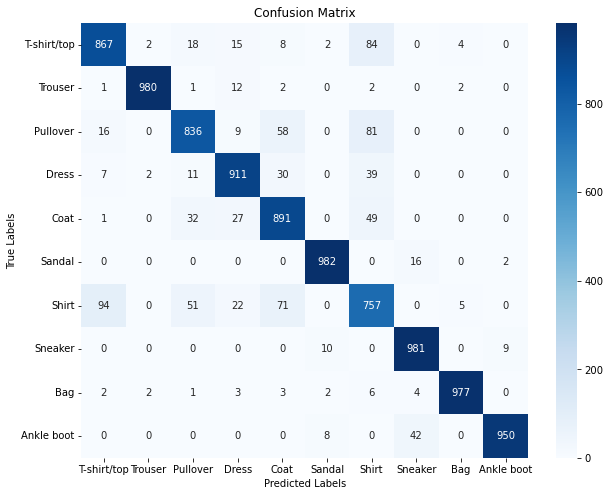

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_enhanced)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Classification Report:

In [40]:
from sklearn.metrics import classification_report

# Print accuracy
print(f"Accuracy: {accuracy_enhanced:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred_enhanced, target_names=label_names))

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_enhanced)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9132
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.88      0.84      0.86      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.84      0.89      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.74      0.76      0.75      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Confusion Matrix:
[[867   2  18  15   8   2  84   0   4   0]
 [  1 980   1  12   2   0   2   0   2   0]
 [ 16   0 836   9  58   0  81   0   0   0]
 [  7   2  11 911  30   0  39   0   0   0]
 [  1   0  

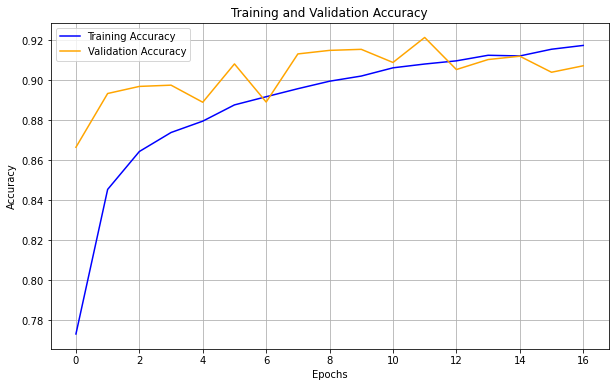

In [38]:
import matplotlib.pyplot as plt

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(enhanced_history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(enhanced_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Comparison of model (part-2) and enhanced model (part-3)

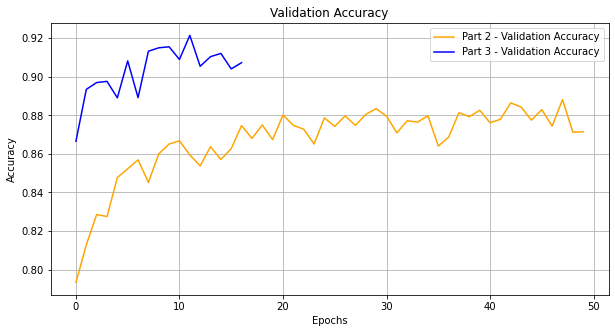

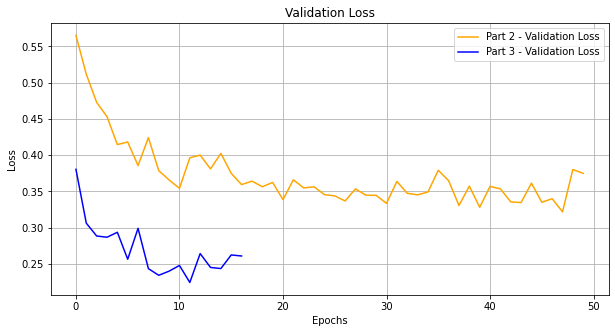

In [34]:
import matplotlib.pyplot as plt

# Plot training and validation accuracies
plt.figure(figsize=(10,5))
# plt.plot(history.history['accuracy'], label='Part 2 - Training Accuracy', color='blue')
plt.plot(augmented_history.history['val_accuracy'], label='Part 2 - Validation Accuracy', color='orange')
# plt.plot(enhanced_history.history['accuracy'], label='Part 3 - Training Accuracy', color='orange')
plt.plot(enhanced_history.history['val_accuracy'], label='Part 3 - Validation Accuracy', color='blue')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses
plt.figure(figsize=(10,5))
# plt.plot(history.history['loss'], label='Part 2 - Training Loss', color='blue')
plt.plot(augmented_history.history['val_loss'], label='Part 2 - Validation Loss', color='orange')
# plt.plot(enhanced_history.history['loss'], label='Part 3 - Training Loss', color='orange')
plt.plot(enhanced_history.history['val_loss'], label='Part 3 - Validation Loss', color='blue')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
